In [31]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import osmnx as ox
import fiona
import pandas as pd
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point
import h3
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Polygon
import folium




# Check all available layers in the shapefile
shapefile_path = "../Data//mazowieckie-latest-free.shp"
layers = fiona.listlayers(shapefile_path)
print("Available layers:", layers)

useful_layers = [
    "gis_osm_buildings_a_free_1",
    "gis_osm_landuse_a_free_1",
    "gis_osm_roads_free_1",
    "gis_osm_transport_free_1",
    "gis_osm_transport_a_free_1",
    "gis_osm_pois_free_1",
    "gis_osm_places_a_free_1",
    "gis_osm_natural_a_free_1"  
]

Available layers: ['gis_osm_landuse_a_free_1', 'gis_osm_natural_free_1', 'gis_osm_buildings_a_free_1', 'gis_osm_waterways_free_1', 'gis_osm_pofw_free_1', 'gis_osm_water_a_free_1', 'gis_osm_transport_free_1', 'gis_osm_places_a_free_1', 'gis_osm_natural_a_free_1', 'gis_osm_places_free_1', 'gis_osm_pofw_a_free_1', 'gis_osm_pois_free_1', 'gis_osm_traffic_a_free_1', 'gis_osm_traffic_free_1', 'gis_osm_railways_free_1', 'gis_osm_transport_a_free_1', 'gis_osm_pois_a_free_1', 'gis_osm_roads_free_1']


In [32]:
def get_osm_data(place_name: str, tags: dict):
    """
    Pobiera dane z OpenStreetMap dla danego obszaru i tagów.

    Parameters:
        place_name (str): nazwa lokalizacji np. "Warszawa, Polska"
        tags (dict): słownik tagów OSM np. {"amenity": "parcel_locker"}

    Returns:
        geopandas.GeoDataFrame
    """
    print(f"Pobieranie danych OSM dla: {tags} w lokalizacji: {place_name}")
    gdf = ox.features_from_place(place_name, tags)
    return gdf

In [33]:
def fetch_osm_features(cities, feature_types, feature_name_map=None):
    """
    Fetch OSM features for cities with optional feature renaming after fetching.
    
    Parameters:
    - cities: list of city names (str)
    - feature_types: dict of OSM tags to fetch, e.g., {'amenity': [...], 'shop': True}
    - feature_name_map: dict mapping original feature values to new names
    
    Returns:
    - DataFrame with columns: city, feature, latitude, longitude
    """
    all_records = []
    feature_name_map = feature_name_map or {}

    for feature_key, feature_values in feature_types.items():
        if feature_values is True:
            for city in cities:
                print(f"Fetching all {feature_key} types in {city}...")
                try:
                    gdf = ox.features_from_place(city, {feature_key: True})
                    if gdf.crs.to_epsg() != 4326:
                        gdf = gdf.to_crs(epsg=4326)
                    for idx, row in gdf.iterrows():
                        geom = row.geometry
                        if geom.geom_type == 'Point':
                            lon, lat = geom.x, geom.y
                        elif geom.geom_type in ['Polygon', 'MultiPolygon']:
                            centroid = geom.centroid
                            lon, lat = centroid.x, centroid.y
                        else:
                            continue
                        # Extract and map feature value
                        feature_value = row.get(feature_key, "unknown")
                        mapped_feature = feature_name_map.get(feature_value, feature_value)
                        all_records.append({
                            'city': city.split(",")[0],
                            'feature': mapped_feature,
                            'latitude': lat,
                            'longitude': lon
                        })
                except Exception as e:
                    print(f"Error for {city} (all {feature_key}): {e}")
        else:
            for feature_value in feature_values:
                tags = {feature_key: feature_value}
                for city in cities:
                    print(f"Fetching {feature_value} in {city}...")
                    try:
                        gdf = ox.features_from_place(city, tags)
                        if gdf.crs.to_epsg() != 4326:
                            gdf = gdf.to_crs(epsg=4326)
                        for idx, row in gdf.iterrows():
                            geom = row.geometry
                            if geom.geom_type == 'Point':
                                lon, lat = geom.x, geom.y
                            elif geom.geom_type in ['Polygon', 'MultiPolygon']:
                                centroid = geom.centroid
                                lon, lat = centroid.x, centroid.y
                            else:
                                continue
                            mapped_feature = feature_name_map.get(feature_value, feature_value)
                            all_records.append({
                                'city': city.split(",")[0],
                                'feature': mapped_feature,
                                'latitude': lat,
                                'longitude': lon
                            })
                    except Exception as e:
                        print(f"Error for {city} ({feature_value}): {e}")

    # Create DataFrame
    df_combined = pd.DataFrame(all_records)

    # Optionally print a message if mapping was applied
    if not df_combined.empty and feature_name_map:
        print("Applying feature_name_map for renaming...")
        unique_features_before = df_combined['feature'].nunique()
        df_combined['feature'] = df_combined['feature'].replace(feature_name_map)
        unique_features_after = df_combined['feature'].nunique()
        print(f"Renamed features from {unique_features_before} to {unique_features_after} unique categories.")
    
    return df_combined

# Example usage
cities = [
    "Warszawa, Polska"
    # , "Wrocław, Polska", "Łódź, Polska", "Poznań, Polska", "Białystok, Polska", 
    #       "Bydgoszcz, Polska"
    #       , "Gdańsk, Polska",
    #     "Chojnice, Polska"
        ]
feature_types = {
    "building": [
        "residential", "apartments", "house", "detached", "semidetached_house", "terrace", "dormitory",
        "static_caravan", "bungalow", "commercial", "retail", "industrial", "warehouse", "office",
        "kiosk", "supermarket"
    ],
    "amenity": [
        "school", "university", "college", "kindergarten", "library",
        "post_office", "parking", "fuel", "bus_station",
        "restaurant", "fast_food", "cafe", "pub", "bar"  # 🍽️ Added food categories!
    ],
    "shop": ["shop", "convenience", "clothes", "bakery", "mall"]
}



feature_name_map = {
    # Residential
    "residential": "residential", "apartments": "residential", "house": "residential", 
    "detached": "residential", "semidetached_house": "residential", "terrace": "residential",
    "dormitory": "residential", "static_caravan": "residential", "bungalow": "residential",

    # Commerce and Shops
    "commercial": "commerce", "retail": "commerce", "industrial": "commerce", 
    "warehouse": "commerce", "office": "commerce", "kiosk": "commerce", 
    
    "supermarket": "shop",
    "shop": "shop", "convenience": "shop", "clothes": "shop", "bakery": "shop",
    "mall": "shop",

    # Education
    "school": "education", "university": "education", "college": "education", "kindergarten": "education",
    "library": "education",

    # Fuel
    "fuel": "gas_station",

    # Food & Restaurants
    "restaurant": "food", "fast_food": "food", "cafe": "food", "pub": "food", "bar": "food"
}

# Fetch data and apply renaming
df_features = fetch_osm_features(cities, feature_types, feature_name_map)




Fetching residential in Warszawa, Polska...
Fetching apartments in Warszawa, Polska...
Fetching house in Warszawa, Polska...
Fetching detached in Warszawa, Polska...
Fetching semidetached_house in Warszawa, Polska...
Fetching terrace in Warszawa, Polska...
Fetching dormitory in Warszawa, Polska...
Fetching static_caravan in Warszawa, Polska...
Fetching bungalow in Warszawa, Polska...
Fetching commercial in Warszawa, Polska...
Fetching retail in Warszawa, Polska...
Fetching industrial in Warszawa, Polska...
Fetching warehouse in Warszawa, Polska...
Fetching office in Warszawa, Polska...
Fetching kiosk in Warszawa, Polska...
Fetching supermarket in Warszawa, Polska...
Fetching school in Warszawa, Polska...
Fetching university in Warszawa, Polska...
Fetching college in Warszawa, Polska...
Fetching kindergarten in Warszawa, Polska...
Fetching library in Warszawa, Polska...
Fetching post_office in Warszawa, Polska...
Fetching parking in Warszawa, Polska...
Fetching fuel in Warszawa, Polska.

In [34]:
# Display results
print(df_features['feature'].value_counts())

feature
residential    107712
parking         19121
commerce        14297
food             4675
shop             3590
education        2400
post_office       249
gas_station       210
bus_station        27
Name: count, dtype: int64


In [35]:
df = df_features


In [36]:

def generate_city_hexes_polyfill(city_name, resolution=8):
    gdf_city = ox.geocode_to_gdf(city_name)
    city_polygon = gdf_city.geometry.unary_union
    
    # Use h3.polyfill if available
    if hasattr(h3, 'polyfill'):
        print("Using h3.polyfill for complete coverage...")
        geojson_polygon = {
            "type": "Polygon",
            "coordinates": [list(city_polygon.exterior.coords)]
        }
        hex_ids = h3.polyfill(geojson_polygon, resolution)
    else:
        print("⚠️ h3.polyfill not available. Switching to dense point sampling...")
        bounds = city_polygon.bounds
        step = 0.001  # Finer step size
        latitudes = list(frange(bounds[1], bounds[3], step))
        longitudes = list(frange(bounds[0], bounds[2], step))
        
        hex_ids = set()
        for lat in latitudes:
            for lon in longitudes:
                hex_id = h3.latlng_to_cell(lat, lon, resolution)
                hex_ids.add(hex_id)
    
    # Convert hexes to polygons
    hex_polygons = []
    for hex_id in hex_ids:
        boundary = h3.cell_to_boundary(hex_id)
        polygon = Polygon([(lon, lat) for lat, lon in boundary])
        if city_polygon.intersects(polygon):
            hex_polygons.append({'h3_index': hex_id, 'geometry': polygon})
    
    gdf_hexes = gpd.GeoDataFrame(hex_polygons, crs='EPSG:4326')
    return gdf_hexes, gdf_city

def frange(start, stop, step):
    while start < stop:
        yield start
        start += step

def display_hexes_on_map(gdf_hexes, gdf_city, city_name, zoom_start=12):
    city_center = (gdf_city.geometry.centroid.y.values[0], gdf_city.geometry.centroid.x.values[0])
    fmap = folium.Map(location=city_center, zoom_start=zoom_start, tiles="cartodbpositron")
    folium.GeoJson(gdf_city.__geo_interface__, name=f"{city_name} Boundary").add_to(fmap)
    
    for _, row in gdf_hexes.iterrows():
        folium.Polygon(
            locations=[(lat, lon) for lon, lat in row['geometry'].exterior.coords],
            color='blue', weight=1, fill=True, fill_opacity=0.3
        ).add_to(fmap)
    
    folium.Marker(location=city_center, popup=f"{city_name} Center", icon=folium.Icon(color='red')).add_to(fmap)
    fmap.save(f"{city_name.replace(',','').replace(' ','_')}_full_hexes.html")
    return fmap


In [37]:
# Run
city_name = "Warszawa, Polska"
resolution = 8

gdf_hexes, gdf_city = generate_city_hexes_polyfill(city_name, resolution)
print(f"Generated {len(gdf_hexes)} full hexes for {city_name}.")
fmap = display_hexes_on_map(gdf_hexes, gdf_city, city_name, zoom_start=11)
fmap

⚠️ h3.polyfill not available. Switching to dense point sampling...
Generated 850 full hexes for Warszawa, Polska.


/var/folders/zw/vcgtv4pj2zj7729jp71l9gvw0000gn/T/ipykernel_12309/1514434169.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  city_polygon = gdf_city.geometry.unary_union
/var/folders/zw/vcgtv4pj2zj7729jp71l9gvw0000gn/T/ipykernel_12309/1514434169.py:43: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  city_center = (gdf_city.geometry.centroid.y.values[0], gdf_city.geometry.centroid.x.values[0])


In [38]:
def count_features_per_hex(df_features, gdf_hexes):
    # Convert to GeoDataFrame
    gdf_points = gpd.GeoDataFrame(
        df_features,
        geometry=gpd.points_from_xy(df_features.longitude, df_features.latitude),
        crs='EPSG:4326'
    )
    
    # Spatial join (use 'within' predicate)
    joined = gpd.sjoin(gdf_points, gdf_hexes, how='inner', predicate='within')
    
    print("Joined columns:", joined.columns)  # 🔍 Inspect column names
    
    # Adjust the column name for h3_index (likely 'h3_index_right')
    hex_column = 'h3_index' if 'h3_index' in joined.columns else 'h3_index_right'
    
    # Group by hex and feature
    feature_counts = joined.groupby([hex_column, 'feature']).size().reset_index(name='count')
    
    # Pivot table
    feature_pivot = feature_counts.pivot_table(index=hex_column, columns='feature', values='count', fill_value=0)
    feature_pivot.reset_index(inplace=True)
    
    # Rename hex_column back to 'h3_index'
    feature_pivot.rename(columns={hex_column: 'h3_index'}, inplace=True)
    
    # Merge back with hexes
    gdf_result = gdf_hexes.merge(feature_pivot, on='h3_index', how='left').fillna(0)
    
    return gdf_result

In [39]:

# Example usage:
# df_features = your original pandas DataFrame
# gdf_hexes = your generated hex GeoDataFrame (for Warsaw)
gdf_counts = count_features_per_hex(df_features, gdf_hexes)

# Preview
gdf_counts.head()

Joined columns: Index(['city', 'feature', 'latitude', 'longitude', 'geometry', 'index_right',
       'h3_index'],
      dtype='object')


,h3_index,geometry,bus_station,commerce,education,food,gas_station,parking,post_office,residential,shop
0,881f522643fffff,"POLYGON ((20.89908 52.22382, 20.89637 52.21968...",0.0,56.0,9.0,5.0,0.0,17.0,1.0,504.0,2.0
1,881f5352a5fffff,"POLYGON ((21.21499 52.16775, 21.21226 52.16362...",0.0,19.0,1.0,0.0,0.0,8.0,0.0,690.0,2.0
2,881f5352bdfffff,"POLYGON ((21.24861 52.17503, 21.24588 52.1709,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0,0.0
3,881f53ca5bfffff,"POLYGON ((21.06296 52.35249, 21.06023 52.34837...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,0.0
4,881f5234b3fffff,"POLYGON ((20.91765 52.24118, 20.91494 52.23704...",0.0,42.0,4.0,0.0,0.0,52.0,0.0,138.0,3.0


In [59]:
import math
import osmnx as ox
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon

# 1️⃣ Categorize landuse values
commercial_vals = {"commercial", "retail", "industrial", "brownfield", "construction", "garages", "quarry", "landfill"}
residential_vals = {"residential", "education", "fairground", "recreation_ground", "village_green"}

def categorize_landuse(v):
    s = str(v).lower().strip()
    if s in commercial_vals: return "commercial_land"
    if s in residential_vals: return "residential_land"
    return "nature_others"

# 2️⃣ Load your hex grid for the city (Warszawa, example)
hex_gdf = gdf_counts  # Or directly use gdf_hexes from your code
city_name = "Warszawa, Polska"
city_boundary = ox.geocode_to_gdf(city_name).to_crs(epsg=2180)
city_polygon = city_boundary.iloc[0].geometry

# 3️⃣ Download OSM landuse polygons
landuse = ox.features_from_place(city_name, {"landuse": True})
landuse = landuse[landuse.geometry.geom_type.isin(["Polygon", "MultiPolygon"])].to_crs(epsg=2180)
landuse["group"] = landuse["landuse"].apply(categorize_landuse)

# 4️⃣ Convert your hex grid to EPSG:2180
hex_gdf = hex_gdf.to_crs(epsg=2180)
hex_gdf["hex_id"] = hex_gdf.index
hex_gdf["hex_area"] = hex_gdf.geometry.area

# 5️⃣ Intersect landuse with hexes
intersections = gpd.overlay(landuse[["group", "geometry"]], hex_gdf[["hex_id", "geometry"]], how="intersection")
intersections["area"] = intersections.geometry.area

# 6️⃣ Summarize area by group per hex
area_summary = (
    intersections.groupby(["hex_id", "group"])["area"]
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)
for col in ["commercial_land", "residential_land"]:
    if col not in area_summary.columns:
        area_summary[col] = 0

# 🔥 1️⃣ Rename columns to land_res and land_comm
area_summary_renamed = area_summary.rename(columns={
    'residential_land': 'land_res',
    'commercial_land': 'land_comm'
}).drop(columns=['geometry'], errors='ignore')

# 2️⃣ Merge with hex_gdf (keeping original columns intact)
hex_gdf = hex_gdf.merge(area_summary_renamed, on='hex_id', how='left')

# 3️⃣ Fill NaN values in new columns with 0
hex_gdf[['land_res', 'land_comm']] = hex_gdf[['land_res', 'land_comm']].fillna(0)

# 4️⃣ Calculate percentages based on land areas
hex_gdf['pct_land_comm'] = (hex_gdf['land_comm'] / hex_gdf['hex_area']).fillna(0) * 100
hex_gdf['pct_land_res'] = (hex_gdf['land_res'] / hex_gdf['hex_area']).fillna(0) * 100
hex_gdf['pct_land_nature_others'] = 100 - hex_gdf['pct_land_comm'] - hex_gdf['pct_land_res']

hex_gdf = hex_gdf.drop(['hex_id','hex_area', 'land_comm','nature_others', 'land_res'],axis = 1)

In [63]:
hex_gdf.head(
)


,h3_index,geometry,bus_station,commerce,education,food,gas_station,parking,post_office,residential,shop,pct_land_comm,pct_land_res,pct_land_nature_others
0,881f522643fffff,"POLYGON ((629676.722 485895.06, 629503.724 485...",0.0,56.0,9.0,5.0,0.0,17.0,1.0,504.0,2.0,6.958369,66.544943,26.496687
1,881f5352a5fffff,"POLYGON ((651436.409 480274.121, 651263.968 47...",0.0,19.0,1.0,0.0,0.0,8.0,0.0,690.0,2.0,1.490312,50.702890,47.806798
2,881f5352bdfffff,"POLYGON ((653709.833 481154.324, 653537.471 48...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0,0.0,0.492607,14.866447,84.640946
3,881f53ca5bfffff,"POLYGON ((640458.442 500506.533, 640285.957 50...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,0.0,2.438994,14.212635,83.348371
4,881f5234b3fffff,"POLYGON ((630893.551 487858.403, 630720.615 48...",0.0,42.0,4.0,0.0,0.0,52.0,0.0,138.0,3.0,18.966186,49.871184,31.162629


In [64]:
gdf_counts.head()


,h3_index,geometry,bus_station,commerce,education,food,gas_station,parking,post_office,residential,shop
0,881f522643fffff,"POLYGON ((20.89908 52.22382, 20.89637 52.21968...",0.0,56.0,9.0,5.0,0.0,17.0,1.0,504.0,2.0
1,881f5352a5fffff,"POLYGON ((21.21499 52.16775, 21.21226 52.16362...",0.0,19.0,1.0,0.0,0.0,8.0,0.0,690.0,2.0
2,881f5352bdfffff,"POLYGON ((21.24861 52.17503, 21.24588 52.1709,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0,0.0
3,881f53ca5bfffff,"POLYGON ((21.06296 52.35249, 21.06023 52.34837...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,0.0
4,881f5234b3fffff,"POLYGON ((20.91765 52.24118, 20.91494 52.23704...",0.0,42.0,4.0,0.0,0.0,52.0,0.0,138.0,3.0


In [ ]:
import folium
import ipywidgets as widgets
from IPython.display import display
import matplotlib.cm as cm
import matplotlib.colors as colors

def display_selected_features_map(gdf_counts, city_center, city_name="Selected City"):
    selected_features = [
        'residential', 'commerce', 'bus_station', 'education', 
        'gas_station', 'parking', 'pct_land_comm', 'pct_land_res', 'pct_land_nature_others'
    ]
    available_features = [f for f in selected_features if f in gdf_counts.columns]
    
    dropdown = widgets.Dropdown(
        options=available_features,
        value=available_features[0],
        description='Feature:',
    )
    
    output = widgets.Output()
    
    def update_map(change):
        feature = dropdown.value
        output.clear_output()
        
        fmap = folium.Map(location=city_center, zoom_start=12, tiles="cartodbpositron")
        
        max_count = gdf_counts[feature].max()
        norm = colors.Normalize(vmin=0, vmax=max_count if max_count > 0 else 1)
        cmap = cm.get_cmap('viridis')
        
        for _, row in gdf_counts.iterrows():
            count = row[feature]
            color = colors.to_hex(cmap(norm(count))) if count > 0 else "#ffffff00"  # Transparent for zero count
            try:
                folium.Polygon(
                    locations=[(lat, lon) for lon, lat in row['geometry'].exterior.coords],
                    color='grey' if count == 0 else color,
                    weight=1,
                    fill=True,
                    fill_opacity=0.6 if count > 0 else 0.1,
                    popup=f"{feature}: {count}"
                ).add_to(fmap)
            except Exception as e:
                print(f"Error with hex: {row['hex_id']}, {e}")
        
        with output:
            display(fmap)
    
    dropdown.observe(update_map, names='value')
    update_map(None)
    
    display(widgets.VBox([dropdown, output]))



In [67]:
if hex_gdf.crs != 'EPSG:4326':
    hex_gdf = hex_gdf.to_crs(epsg=4326)

# Now the map should work perfectly!
city_center = (gdf_city.geometry.centroid.y.values[0], gdf_city.geometry.centroid.x.values[0])
display_selected_features_map(hex_gdf, city_center, city_name="Warszawa")

/var/folders/zw/vcgtv4pj2zj7729jp71l9gvw0000gn/T/ipykernel_12309/3930888283.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  city_center = (gdf_city.geometry.centroid.y.values[0], gdf_city.geometry.centroid.x.values[0])
/var/folders/zw/vcgtv4pj2zj7729jp71l9gvw0000gn/T/ipykernel_12309/398205739.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


In [68]:
hex_gdf

,h3_index,geometry,bus_station,commerce,education,food,gas_station,parking,post_office,residential,shop,pct_land_comm,pct_land_res,pct_land_nature_others
0,881f522643fffff,"POLYGON ((20.89908 52.22382, 20.89637 52.21968...",0.0,56.0,9.0,5.0,0.0,17.0,1.0,504.0,2.0,6.958369,66.544943,26.496687
1,881f5352a5fffff,"POLYGON ((21.21499 52.16775, 21.21226 52.16362...",0.0,19.0,1.0,0.0,0.0,8.0,0.0,690.0,2.0,1.490312,50.702890,47.806798
2,881f5352bdfffff,"POLYGON ((21.24861 52.17503, 21.24588 52.1709,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0,0.0,0.492607,14.866447,84.640946
3,881f53ca5bfffff,"POLYGON ((21.06296 52.35249, 21.06023 52.34837...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,0.0,2.438994,14.212635,83.348371
4,881f5234b3fffff,"POLYGON ((20.91765 52.24118, 20.91494 52.23704...",0.0,42.0,4.0,0.0,0.0,52.0,0.0,138.0,3.0,18.966186,49.871184,31.162629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,881f53c8edfffff,"POLYGON ((21.0904 52.26293, 21.08768 52.25879,...",0.0,42.0,1.0,0.0,0.0,4.0,0.0,12.0,0.0,26.278750,2.620938,71.100313
846,881f53c8cdfffff,"POLYGON ((21.10904 52.28025, 21.10631 52.27612...",0.0,2.0,0.0,0.0,0.0,8.0,0.0,11.0,2.0,1.229166,3.415187,95.355647
847,881f53515bfffff,"POLYGON ((21.12688 52.1433, 21.12416 52.13916,...",0.0,6.0,0.0,0.0,0.0,0.0,0.0,62.0,0.0,4.016725,11.832523,84.150752
848,881f535327fffff,"POLYGON ((21.06557 52.14855, 21.06286 52.14441...",0.0,0.0,2.0,0.0,0.0,6.0,0.0,144.0,1.0,0.584436,25.935472,73.480092


In [70]:
df_paczkomat = pd.read_csv('../Data/points_export.csv')

In [72]:
gdf_paczkomat = gpd.GeoDataFrame(
    df_paczkomat,  # Your paczkomat DataFrame
    geometry=gpd.points_from_xy(df_paczkomat['lon'], df_paczkomat['lat']),
    crs="EPSG:4326"  # Assuming coordinates are in lat/lon
)

# 2️⃣ Make sure your hex_gdf is also in EPSG:4326
if hex_gdf.crs != "EPSG:4326":
    hex_gdf = hex_gdf.to_crs(epsg=4326)

# 3️⃣ Spatial join to assign each paczkomat to its hexagon
joined = gpd.sjoin(gdf_paczkomat, hex_gdf[['h3_index', 'geometry']], how='inner', predicate='within')

# 4️⃣ Count the number of paczkomats per hex
paczkomat_counts = joined.groupby('h3_index').size().reset_index(name='number_paczkomat')

# 5️⃣ Merge the counts into hex_gdf
hex_gdf = hex_gdf.merge(paczkomat_counts, on='h3_index', how='left')

# 6️⃣ Fill NaN (hexes with 0 paczkomats)
hex_gdf['number_paczkomat'] = hex_gdf['number_paczkomat'].fillna(0).astype(int)

# 7️⃣ 🎉 Now hex_gdf has the column 'number_paczkomat'!
print(hex_gdf[['h3_index', 'number_paczkomat']].head())

          h3_index  number_paczkomat
0  881f522643fffff                 3
1  881f5352a5fffff                 0
2  881f5352bdfffff                 0
3  881f53ca5bfffff                 0
4  881f5234b3fffff                 2


In [73]:
import folium
import ipywidgets as widgets
from IPython.display import display
import matplotlib.cm as cm
import matplotlib.colors as colors

def display_selected_features_map(gdf_counts, city_center, city_name="Selected City"):
    selected_features = [
        'residential', 'commerce', 'bus_station', 'education', 
        'gas_station', 'parking', 'pct_land_comm', 'pct_land_res', 'pct_land_nature_others', 'number_paczkomat'
    ]
    available_features = [f for f in selected_features if f in gdf_counts.columns]
    
    dropdown = widgets.Dropdown(
        options=available_features,
        value=available_features[0],
        description='Feature:',
    )
    
    output = widgets.Output()
    
    def update_map(change):
        feature = dropdown.value
        output.clear_output()
        
        fmap = folium.Map(location=city_center, zoom_start=12, tiles="cartodbpositron")
        
        max_count = gdf_counts[feature].max()
        norm = colors.Normalize(vmin=0, vmax=max_count if max_count > 0 else 1)
        cmap = cm.get_cmap('viridis')
        
        for _, row in gdf_counts.iterrows():
            count = row[feature]
            color = colors.to_hex(cmap(norm(count))) if count > 0 else "#ffffff00"  # Transparent for zero count
            try:
                folium.Polygon(
                    locations=[(lat, lon) for lon, lat in row['geometry'].exterior.coords],
                    color='grey' if count == 0 else color,
                    weight=1,
                    fill=True,
                    fill_opacity=0.6 if count > 0 else 0.1,
                    popup=f"{feature}: {count}"
                ).add_to(fmap)
            except Exception as e:
                print(f"Error with hex: {row['hex_id']}, {e}")
        
        with output:
            display(fmap)
    
    dropdown.observe(update_map, names='value')
    update_map(None)
    
    display(widgets.VBox([dropdown, output]))



In [74]:
if hex_gdf.crs != 'EPSG:4326':
    hex_gdf = hex_gdf.to_crs(epsg=4326)

# Now the map should work perfectly!
city_center = (gdf_city.geometry.centroid.y.values[0], gdf_city.geometry.centroid.x.values[0])
display_selected_features_map(hex_gdf, city_center, city_name="Warszawa")

/var/folders/zw/vcgtv4pj2zj7729jp71l9gvw0000gn/T/ipykernel_12309/3930888283.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  city_center = (gdf_city.geometry.centroid.y.values[0], gdf_city.geometry.centroid.x.values[0])
/var/folders/zw/vcgtv4pj2zj7729jp71l9gvw0000gn/T/ipykernel_12309/3620837083.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


In [79]:
df_final

,h3_index,geometry,bus_station,commerce,education,food,gas_station,parking,post_office,residential,shop,pct_land_comm,pct_land_res,pct_land_nature_others,number_paczkomat
0,881f522643fffff,"POLYGON ((20.89908 52.22382, 20.89637 52.21968...",0.0,56.0,9.0,5.0,0.0,17.0,1.0,504.0,2.0,6.958369,66.544943,26.496687,3
1,881f5352a5fffff,"POLYGON ((21.21499 52.16775, 21.21226 52.16362...",0.0,19.0,1.0,0.0,0.0,8.0,0.0,690.0,2.0,1.490312,50.702890,47.806798,0
2,881f5352bdfffff,"POLYGON ((21.24861 52.17503, 21.24588 52.1709,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0,0.0,0.492607,14.866447,84.640946,0
3,881f53ca5bfffff,"POLYGON ((21.06296 52.35249, 21.06023 52.34837...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,0.0,2.438994,14.212635,83.348371,0
4,881f5234b3fffff,"POLYGON ((20.91765 52.24118, 20.91494 52.23704...",0.0,42.0,4.0,0.0,0.0,52.0,0.0,138.0,3.0,18.966186,49.871184,31.162629,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,881f53c8edfffff,"POLYGON ((21.0904 52.26293, 21.08768 52.25879,...",0.0,42.0,1.0,0.0,0.0,4.0,0.0,12.0,0.0,26.278750,2.620938,71.100313,0
846,881f53c8cdfffff,"POLYGON ((21.10904 52.28025, 21.10631 52.27612...",0.0,2.0,0.0,0.0,0.0,8.0,0.0,11.0,2.0,1.229166,3.415187,95.355647,3
847,881f53515bfffff,"POLYGON ((21.12688 52.1433, 21.12416 52.13916,...",0.0,6.0,0.0,0.0,0.0,0.0,0.0,62.0,0.0,4.016725,11.832523,84.150752,0
848,881f535327fffff,"POLYGON ((21.06557 52.14855, 21.06286 52.14441...",0.0,0.0,2.0,0.0,0.0,6.0,0.0,144.0,1.0,0.584436,25.935472,73.480092,0


In [81]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import shap


In [95]:
# 1️⃣ Prepare the DataFrame
# Assuming your dataframe is called 'hex_gdf'
df = df_final.drop(columns=['h3_index', 'geometry'])


In [120]:
df.to_csv('../Data/koncowy_df_Warszawa.csv')

In [96]:

# Define features (X) and target (y)
X = df.drop(columns=['number_paczkomat'])
y = df['number_paczkomat']


In [97]:

# 2️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [116]:

# 3️⃣ Train XGBoost model
model = xgb.XGBRegressor(
    n_estimators=30,         # More trees
    max_depth=3,              # Shallower trees to prevent overfitting
    learning_rate=0.05,       # Slower learning rate
    subsample=0.8,            # Row sampling
    colsample_bytree=0.8,     # Feature sampling
    reg_alpha=1,              # L1 regularization
    reg_lambda=1,             # L2 regularization
    random_state=420
)


In [117]:
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=30,
             n_jobs=None, num_parallel_tree=None, ...)

In [118]:
# 4️⃣ Predict and evaluate

# On test data
y_pred_test = model.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f"Test R² Score: {r2_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")

# On train data
y_pred_train = model.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
print(f"Train R² Score: {r2_train:.4f}")
print(f"Train MAE: {mae_train:.4f}")


Test R² Score: 0.4968
Test MAE: 1.3712
Train R² Score: 0.6181
Train MAE: 1.2709


In [119]:

# 5️⃣ SHAP analysis
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)


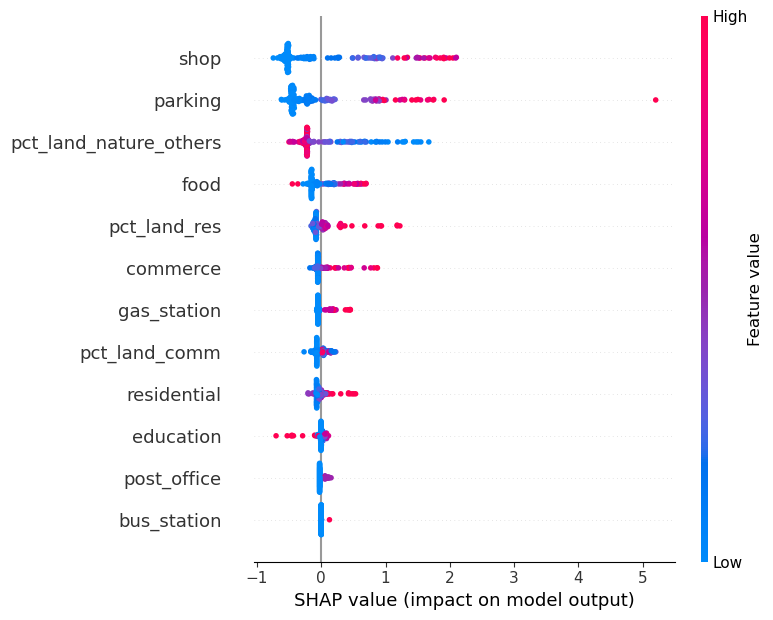

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

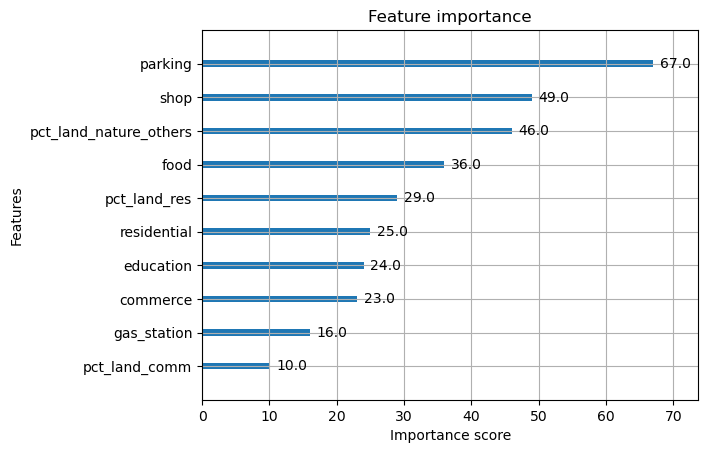

In [115]:

# Summary plot
shap.summary_plot(shap_values, X_test)

# Optional: Feature importance
xgb.plot_importance(model, max_num_features=10)

In [ ]:
# import h3
# import folium
# import pandas as pd
# import geopandas as gpd
# from shapely.geometry import Polygon
# import osmnx as ox
# import matplotlib.cm as cm
# import matplotlib.colors as colors

# def aggregate_features_with_h3(df, resolution=8):
#     if not {'latitude', 'longitude', 'feature'}.issubset(df.columns):
#         raise ValueError("DataFrame must contain 'latitude', 'longitude', and 'feature' columns")
    
#     df['h3_index'] = df.apply(lambda row: h3.latlng_to_cell(row['latitude'], row['longitude'], resolution), axis=1)
#     hex_counts = df.groupby(['h3_index', 'feature']).size().reset_index(name='count')
#     return hex_counts

# def create_hex_geometries(hex_counts):
#     hex_geoms = []
#     for idx, row in hex_counts.iterrows():
#         try:
#             hex_boundary = h3.cell_to_boundary(row['h3_index'])
#             polygon = Polygon([(lon, lat) for lat, lon in hex_boundary])
#             if not polygon.is_valid:
#                 continue
#             hex_geoms.append({
#                 'h3_index': row['h3_index'],
#                 'feature': row['feature'],
#                 'count': row['count'],
#                 'geometry': polygon
#             })
#         except Exception as e:
#             print(f"⚠️ Error creating polygon for H3 index {row['h3_index']}: {e}")
#             continue
#     return gpd.GeoDataFrame(hex_geoms, geometry='geometry', crs='EPSG:4326')

# def create_interactive_map_with_hexes(gdf_hexes, city_center, city_boundary=None, zoom_start=12):
#     fmap = folium.Map(location=city_center, zoom_start=zoom_start, tiles="cartodbpositron")
    
#     if city_boundary is not None:
#         folium.GeoJson(city_boundary, name="City Boundary").add_to(fmap)
    
#     norm = colors.Normalize(vmin=gdf_hexes['count'].min(), vmax=gdf_hexes['count'].max())
#     cmap = cm.get_cmap('viridis')
    
#     for idx, row in gdf_hexes.iterrows():
#         color = colors.to_hex(cmap(norm(row['count'])))
#         folium.Polygon(
#             locations=[(lat, lon) for lon, lat in row['geometry'].exterior.coords],
#             color=color,
#             weight=1,
#             fill=True,
#             fill_opacity=0.6,
#             popup=f"Feature: {row['feature']}, Count: {row['count']}"
#         ).add_to(fmap)
    
#     folium.Marker(location=city_center, popup="Warszawa City Center", icon=folium.Icon(color='red')).add_to(fmap)
    
#     return fmap

# # 🌍 Define city and get city boundary & center
# city_name = "Warszawa, Polska"
# gdf_city = ox.geocode_to_gdf(city_name)
# city_center = (gdf_city.geometry.centroid.y.values[0], gdf_city.geometry.centroid.x.values[0])
# city_boundary = gdf_city.__geo_interface__

# # 🔄 Step 1: Assuming df is already loaded with columns: city, feature, latitude, longitude
# # df = fetch_osm_features(cities=['Warszawa, Polska'], feature_types, feature_name_map)

# # 🔄 Step 2: Aggregate features into H3 hexes
# resolution = 10
# hex_counts = aggregate_features_with_h3(df, resolution=resolution)

# # 🔄 Step 3: Convert to GeoDataFrame of hex polygons
# gdf_hexes = create_hex_geometries(hex_counts)

# # 🔄 Step 4: Create and display interactive map
# if not gdf_hexes.empty:
#     fmap = create_interactive_map_with_hexes(gdf_hexes, city_center, city_boundary, zoom_start=12)
#     fmap.save("warszawa_features_h3_map.html")
#     display(fmap)
# else:
#     print("⚠️ No hexes to display on map.")

/var/folders/zw/vcgtv4pj2zj7729jp71l9gvw0000gn/T/ipykernel_11714/3871702708.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  city_polygon = gdf_city.geometry.unary_union
/var/folders/zw/vcgtv4pj2zj7729jp71l9gvw0000gn/T/ipykernel_11714/3871702708.py:49: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  city_center = (gdf_city.geometry.centroid.y.values[0], gdf_city.geometry.centroid.x.values[0])


⚠️ h3.polyfill not available. Switching to dense point sampling...
Generated 850 full hexes for Warszawa, Polska.


In [14]:
gdf_hexes


,h3_index,geometry
0,881f53c951fffff,"POLYGON ((20.99535 52.26082, 20.99263 52.25669..."
1,881f535a5dfffff,"POLYGON ((21.0307 52.10634, 21.02799 52.10219,..."
2,881f53c9a3fffff,"POLYGON ((21.06003 52.20584, 21.05731 52.20171..."
3,881f53c9c7fffff,"POLYGON ((21.05088 52.23574, 21.04816 52.2316,..."
4,881f53d991fffff,"POLYGON ((20.98054 52.34784, 20.97782 52.34371..."
...,...,...
845,881f535351fffff,"POLYGON ((21.10049 52.19073, 21.09777 52.1866,..."
846,881f53cb39fffff,"POLYGON ((20.97571 52.28575, 20.973 52.28162, ..."
847,881f522669fffff,"POLYGON ((20.86548 52.21645, 20.86277 52.21231..."
848,881f53c945fffff,"POLYGON ((20.94897 52.256, 20.94626 52.25187, ..."


In [ ]:

# Example usage:
# df_features = your original pandas DataFrame
# gdf_hexes = your generated hex GeoDataFrame (for Warsaw)
gdf_counts = count_features_per_hex(df_features, gdf_hexes)

# Preview
print(gdf_counts.head())

Joined columns: Index(['city', 'feature', 'latitude', 'longitude', 'h3_index_left', 'geometry',
       'index_right', 'h3_index_right'],
      dtype='object')
          h3_index                                           geometry  \
0  881f53c951fffff  POLYGON ((20.99535 52.26082, 20.99263 52.25669...   
1  881f535a5dfffff  POLYGON ((21.0307 52.10634, 21.02799 52.10219,...   
2  881f53c9a3fffff  POLYGON ((21.06003 52.20584, 21.05731 52.20171...   
3  881f53c9c7fffff  POLYGON ((21.05088 52.23574, 21.04816 52.2316,...   
4  881f53d991fffff  POLYGON ((20.98054 52.34784, 20.97782 52.34371...   

   bus_station  commerce  education  food  gas_station  parking  post_office  \
0          0.0      18.0        3.0   9.0          0.0     48.0          1.0   
1          0.0       0.0        0.0   0.0          0.0      0.0          0.0   
2          0.0       1.0        0.0   1.0          0.0     17.0          0.0   
3          0.0      45.0       17.0  50.0          0.0     17.0          2.0   
4 

In [ ]:
import folium
import ipywidgets as widgets
from IPython.display import display

def display_feature_map(gdf_counts, city_center, city_name="Selected City"):
    # Create dropdown with available features
    available_features = [col for col in gdf_counts.columns if col not in ['h3_index', 'geometry']]
    
    dropdown = widgets.Dropdown(
        options=available_features,
        value=available_features[0],
        description='Feature:',
    )
    
    output = widgets.Output()
    
    def update_map(change):
        feature = dropdown.value
        output.clear_output()
        
        # Create folium map
        fmap = folium.Map(location=city_center, zoom_start=12, tiles="cartodbpositron")
        
        # Color scale
        max_count = gdf_counts[feature].max()
        if max_count == 0:
            max_count = 1  # Avoid division by zero
        
        for _, row in gdf_counts.iterrows():
            color = cm.get_cmap('viridis')(row[feature] / max_count)
            color_hex = colors.to_hex(color)
            folium.Polygon(
                locations=[(lat, lon) for lon, lat in row['geometry'].exterior.coords],
                color=color_hex,
                weight=1,
                fill=True,
                fill_opacity=0.6,
                popup=f"{feature}: {row[feature]}"
            ).add_to(fmap)
        
        with output:
            display(fmap)
    
    dropdown.observe(update_map, names='value')
    
    # Initial map display
    update_map(None)
    
    display(widgets.VBox([dropdown, output]))

# Usage example
city_center = (gdf_city.geometry.centroid.y.values[0], gdf_city.geometry.centroid.x.values[0])  # Center of Warsaw


/var/folders/zw/vcgtv4pj2zj7729jp71l9gvw0000gn/T/ipykernel_11714/20285675.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  city_center = (gdf_city.geometry.centroid.y.values[0], gdf_city.geometry.centroid.x.values[0])  # Center of Warsaw


In [ ]:
import folium
import ipywidgets as widgets
from IPython.display import display
import matplotlib.cm as cm
import matplotlib.colors as colors

def display_selected_features_map(gdf_counts, city_center, city_name="Selected City"):
    # Focus only on residential and commerce features
    selected_features = ['residential', 'commerce']
    available_features = [f for f in selected_features if f in gdf_counts.columns]
    
    dropdown = widgets.Dropdown(
        options=available_features,
        value=available_features[0],
        description='Feature:',
    )
    
    output = widgets.Output()
    
    def update_map(change):
        feature = dropdown.value
        output.clear_output()
        
        fmap = folium.Map(location=city_center, zoom_start=12, tiles="cartodbpositron")
        
        # Filter to only hexes with non-zero counts for the selected feature
        filtered = gdf_counts[gdf_counts[feature] > 0]
        if filtered.empty:
            print(f"No data for feature: {feature}")
            return
        
        max_count = filtered[feature].max()
        norm = colors.Normalize(vmin=0, vmax=max_count)
        cmap = cm.get_cmap('viridis')
        
        for _, row in filtered.iterrows():
            color = colors.to_hex(cmap(norm(row[feature])))
            folium.Polygon(
                locations=[(lat, lon) for lon, lat in row['geometry'].exterior.coords],
                color=color,
                weight=1,
                fill=True,
                fill_opacity=0.6,
                popup=f"{feature}: {row[feature]}"
            ).add_to(fmap)
        
        with output:
            display(fmap)
    
    dropdown.observe(update_map, names='value')
    
    update_map(None)
    
    display(widgets.VBox([dropdown, output]))

# Usage example:
city_center = (gdf_city.geometry.centroid.y.values[0], gdf_city.geometry.centroid.x.values[0])  # Center of Warsaw
display_selected_features_map(gdf_counts, city_center, city_name="Warszawa")

In [ ]:
display_feature_map(gdf_counts, city_center, city_name="Warszawa")

In [99]:
import pandas as pd

# Assuming your dataset is named df and already has columns: city, feature, latitude, longitude, h3_index

# Group by h3_index and feature, and count occurrences
hex_feature_counts = df.groupby(['h3_index', 'feature']).size().reset_index(name='count')

# Pivot the table to have h3_index as rows and feature types as columns
hex_pivot = hex_feature_counts.pivot_table(index='h3_index', columns='feature', values='count', fill_value=0).reset_index()

# Optional: Fill missing features with 0 and flatten columns
hex_pivot.columns.name = None  # Remove the pivot table index name
hex_pivot.fillna(0, inplace=True)

# Display the resulting DataFrame
print(hex_pivot.head())

          h3_index  bus_station  commerce  education  food  gas_station  \
0  8a1f52240a6ffff          0.0       0.0        0.0   0.0          0.0   
1  8a1f52240b2ffff          0.0       2.0        0.0   1.0          0.0   
2  8a1f52240b47fff          0.0       3.0        3.0   0.0          0.0   
3  8a1f52240b4ffff          0.0       1.0        0.0   0.0          0.0   
4  8a1f52240b67fff          0.0       0.0        0.0   0.0          0.0   

   parking  post_office  residential  shop  
0      0.0          0.0          7.0   0.0  
1      0.0          0.0          3.0   0.0  
2      0.0          0.0          5.0   0.0  
3      1.0          0.0          1.0   0.0  
4      0.0          0.0          7.0   0.0  


In [100]:
hex_pivot

,h3_index,bus_station,commerce,education,food,gas_station,parking,post_office,residential,shop
0,8a1f52240a6ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0
1,8a1f52240b2ffff,0.0,2.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0
2,8a1f52240b47fff,0.0,3.0,3.0,0.0,0.0,0.0,0.0,5.0,0.0
3,8a1f52240b4ffff,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,8a1f52240b67fff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...
21466,8a1f53d9eb4ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
21467,8a1f53d9eb57fff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0
21468,8a1f53d9eb5ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
21469,8a1f53d9eb6ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:

import matplotlib.pyplot as plt
gdf_hexes.plot(column='count', cmap='viridis', edgecolor='black', figsize=(10,10), legend=True)
plt.show()

In [189]:

# 🧠 Example Usage
# Fetch OSM features using your previous function
# df = fetch_osm_features(cities, feature_types, feature_name_map)

# 🚀 Step 1️⃣: Aggregate by H3 hexes
hex_counts = aggregate_features_with_h3(df, resolution=8)

# 🚀 Step 2️⃣: Convert hex indices to geometries
gdf_hexes = display_hexes(hex_counts)


AttributeError: module 'h3.api.basic_int' has no attribute 'geo_to_h3'

In [ ]:

# 🚀 Step 3️⃣: Visualize or explore
print(gdf_hexes.head())

# Optional: plot using geopandas/matplotlib
import matplotlib.pyplot as plt
gdf_hexes.plot(column='count', cmap='viridis', edgecolor='black', figsize=(10,10), legend=True)
plt.title('Feature Counts per H3 Hex')
plt.show()

In [ ]:

df_features = fetch_osm_features(cities, feature_types)


In [108]:
df_features.feature.value_counts()

feature
residential           4872
parking               4001
house                 3472
detached              2213
apartments            2064
industrial            1333
retail                 502
bungalow               440
commercial             196
warehouse              166
office                 164
terrace                 91
fuel                    51
post_office             43
dormitory               19
semidetached_house      17
supermarket              5
bus_station              1
Name: count, dtype: int64

In [143]:
def fetch_osm_features(cities, feature_types, feature_name_map=None):
    """
    Fetch specified OSM features for given cities, with optional feature renaming after fetching.
    
    Parameters:
    - cities: list of city names (str)
    - feature_types: dict of OSM tags to fetch, e.g., {'building': ['residential', 'apartments', 'house']}
    - feature_name_map: dict mapping original feature values to new names, e.g., {'apartments': 'residential'}
    
    Returns:
    - pandas DataFrame with columns: city, feature, latitude, longitude
    """
    all_records = []
    feature_name_map = feature_name_map or {}  # Ensure it's a dictionary

    # Step 1️⃣: Fetch all features with original names
    for feature_key, feature_values in feature_types.items():
        for feature_value in feature_values:
            tags = {feature_key: feature_value}
            for city in cities:
                print(f"Fetching {feature_value} in {city}...")
                try:
                    gdf = ox.features_from_place(city, tags)
                    if gdf.crs.to_epsg() != 4326:
                        gdf = gdf.to_crs(epsg=4326)
                    for idx, row in gdf.iterrows():
                        geom = row.geometry
                        if geom.geom_type == 'Point':
                            lon, lat = geom.x, geom.y
                        elif geom.geom_type in ['Polygon', 'MultiPolygon']:
                            centroid = geom.centroid
                            lon, lat = centroid.x, centroid.y
                        else:
                            continue
                        all_records.append({
                            'city': city.split(",")[0],
                            'feature': feature_value,  # Keep original tag
                            'latitude': lat,
                            'longitude': lon
                        })
                except Exception as e:
                    print(f"Error for {city} ({feature_value}): {e}")
    
    # Step 2️⃣: Create DataFrame
    df_combined = pd.DataFrame(all_records)
    
    # Step 3️⃣: Rename rows in 'feature' column based on mapping
    if not df_combined.empty and feature_name_map:
        df_combined['feature'] = df_combined['feature'].replace(feature_name_map)
    
    return df_combined

# Example usage
cities = ["Bydgoszcz, Polska"]
feature_types = {
    "building": ["residential", "apartments", "house", "detached", "semidetached_house", "terrace", "dormitory", "static_caravan", "bungalow",
                 "commercial", "retail", "industrial", "warehouse", "office", "kiosk", "supermarket"],
    "amenity": ["parking", "fuel", "post_office", "bus_station"]
}
feature_name_map = {
    "apartments": "residential",
    "house": "residential",
    "detached": "residential",
    "semidetached_house": "residential",
    "terrace": "residential",
    "dormitory": "residential",
    "static_caravan": "residential",
    "bungalow": "residential",
    "commercial": "commerce",
    "retail": "commerce",
    "industrial": "commerce",
    "warehouse": "commerce",
    "office": "commerce",
    "kiosk": "commerce",
    "supermarket": "commerce",
    "fuel": "gas_station"
}

# Fetch data and apply renaming
df_features = fetch_osm_features(cities, feature_types, feature_name_map)

# Display results
print(df_features['feature'].value_counts())
print(df_features.head())

Fetching residential in Bydgoszcz, Polska...
Fetching apartments in Bydgoszcz, Polska...
Fetching house in Bydgoszcz, Polska...
Fetching detached in Bydgoszcz, Polska...
Fetching semidetached_house in Bydgoszcz, Polska...
Fetching terrace in Bydgoszcz, Polska...
Fetching dormitory in Bydgoszcz, Polska...
Fetching static_caravan in Bydgoszcz, Polska...
Error for Bydgoszcz, Polska (static_caravan): No matching features. Check query location, tags, and log.
Fetching bungalow in Bydgoszcz, Polska...
Fetching commercial in Bydgoszcz, Polska...
Fetching retail in Bydgoszcz, Polska...
Fetching industrial in Bydgoszcz, Polska...
Fetching warehouse in Bydgoszcz, Polska...
Fetching office in Bydgoszcz, Polska...
Fetching kiosk in Bydgoszcz, Polska...
Error for Bydgoszcz, Polska (kiosk): No matching features. Check query location, tags, and log.
Fetching supermarket in Bydgoszcz, Polska...
Fetching parking in Bydgoszcz, Polska...
Fetching fuel in Bydgoszcz, Polska...
Fetching post_office in Bydgo

In [111]:
df_features.feature.value_counts()

feature
residential    13188
parking         4001
commerce        2366
gas_station       51
post_office       43
bus_station        1
Name: count, dtype: int64

In [83]:

# Example usage
cities = ["Warszawa, Polska", "Wrocław, Polska", "Łódź, Polska", "Poznań, Polska", "Białystok, Polska", "Bydgoszcz, Polska", "Gdańsk, Polska"]
feature_types = {
    "building": ["residential", "apartments", "retail"]
}

df_features = fetch_osm_features(cities, feature_types)


Fetching residential in Warszawa, Polska...
Fetching residential in Wrocław, Polska...
Fetching residential in Łódź, Polska...
Fetching residential in Poznań, Polska...
Fetching residential in Białystok, Polska...
Fetching residential in Bydgoszcz, Polska...
Fetching residential in Gdańsk, Polska...
Fetching apartments in Warszawa, Polska...
Fetching apartments in Wrocław, Polska...
Fetching apartments in Łódź, Polska...
Fetching apartments in Poznań, Polska...
Fetching apartments in Białystok, Polska...
Fetching apartments in Bydgoszcz, Polska...
Fetching apartments in Gdańsk, Polska...
Fetching retail in Warszawa, Polska...
Fetching retail in Wrocław, Polska...
Fetching retail in Łódź, Polska...
Fetching retail in Poznań, Polska...
Fetching retail in Białystok, Polska...
Fetching retail in Bydgoszcz, Polska...
Fetching retail in Gdańsk, Polska...


In [84]:
df_features.feature.value_counts()

feature
apartments     48763
residential    14826
retail         10963
Name: count, dtype: int64

In [74]:
df_features.feature.value_counts()

feature
parking          55181
parcel_locker     5221
post_office        699
fuel               654
Name: count, dtype: int64

In [ ]:

# Optional: save to CSV
df_features.to_csv("osm_features_multi_cities.csv", index=False)

In [ ]:

# (Optional) save to CSV
df_parking.to_csv("parking_locations_multi_cities.csv", index=False)

In [55]:

# Tworzenie DataFrame
import pandas as pd
df_parking = pd.DataFrame(coordinates)


In [56]:

# Wyświetlenie wyników
print(f"Pobrano {len(df_parking)} parkingów w Warszawie")
print(df_parking.head())


Pobrano 19121 parkingów w Warszawie
  name   latitude  longitude
0  NaN  52.264533  20.929890
1  NaN  52.253557  20.930553
2  NaN  52.256665  20.943058
3  NaN  52.246632  20.982364
4  NaN  52.247978  20.983102


In [ ]:

# (Opcjonalnie) zapis do pliku CSV
df_parking.to_csv("warsaw_parking_locations.csv", index=False)

In [47]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import requests
import osmnx as ox

# 🔶 1️⃣ Pobranie paczkomatów z OSM
overpass_url = "http://overpass-api.de/api/interpreter"
query_paczkomaty = """
[out:json][timeout:25];
area["name"="Poland"]->.searchArea;
node["amenity"="parcel_locker"](area.searchArea);
out body;
"""
response_paczkomaty = requests.get(overpass_url, params={'data': query_paczkomaty})
data_paczkomaty = response_paczkomaty.json()

paczkomaty_list = []
for node in data_paczkomaty['elements']:
    paczkomaty_list.append({
        'name': node.get('name', 'unknown'),
        'operator': node.get('operator', 'unknown'),
        'latitude': node['lat'],
        'longitude': node['lon']
    })
gdf_paczkomaty = gpd.GeoDataFrame(
    paczkomaty_list,
    geometry=gpd.points_from_xy([n['longitude'] for n in paczkomaty_list],
                                [n['latitude'] for n in paczkomaty_list]),
    crs="EPSG:4326"
)
print(f"Pobrano {len(gdf_paczkomaty)} paczkomatów z OSM")

# 🔶 2️⃣ Lista dużych miast w Polsce (ręcznie lub z GUS)
# Na potrzeby przykładu lista dużych miast
miasta_duze = [
    {'name': 'Warszawa', 'population': 1790658},
    {'name': 'Kraków', 'population': 800653},
    {'name': 'Łódź', 'population': 672185},
    {'name': 'Wrocław', 'population': 640648},
    {'name': 'Poznań', 'population': 535802},
    {'name': 'Gdańsk', 'population': 470907},
    {'name': 'Szczecin', 'population': 398255},
    {'name': 'Bydgoszcz', 'population': 344091},
    {'name': 'Lublin', 'population': 337788}
]

city_gdfs = []
for city in miasta_duze:
    city_name = city['name']
    population = city['population']
    try:
        gdf_city = ox.geocode_to_gdf(f"{city_name}, Poland")
        gdf_city['name'] = city_name
        gdf_city['population'] = population
        city_gdfs.append(gdf_city)
    except Exception as e:
        print(f"Błąd pobierania geometrii dla {city_name}: {e}")

# Połącz wszystkie miasta w jeden GeoDataFrame
gdf_cities = pd.concat(city_gdfs, ignore_index=True)
print(f"Pobrano geometrię {len(gdf_cities)} dużych miast")

# 🔶 3️⃣ Przypisanie paczkomatów do miast
joined = gpd.sjoin(gdf_paczkomaty, gdf_cities, how="inner", predicate="within")

# 🔶 4️⃣ Liczenie paczkomatów w każdym mieście
paczkomaty_count = joined.groupby('name').size().reset_index(name='paczkomaty_count')
paczkomaty_count = paczkomaty_count.sort_values(by='paczkomaty_count', ascending=False)

# 🔶 5️⃣ Wynik
print("\nLiczba paczkomatów w miastach powyżej 200 tys mieszkańców:")
print(paczkomaty_count)

Pobrano 0 paczkomatów z OSM
Pobrano geometrię 9 dużych miast

Liczba paczkomatów w miastach powyżej 200 tys mieszkańców:
Empty DataFrame
Columns: [name, paczkomaty_count]
Index: []


In [46]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import osmnx as ox

# 1️⃣ Wczytaj dane paczkomatów (np. z JSON, OSM, API)
# Zakładamy, że masz DataFrame z kolumnami: latitude, longitude, operator
# Przykład (z InPost/OSM)
df_paczkomaty = pd.read_csv("paczkomaty_combined.csv")  # lub stwórz DataFrame z API

# Stwórz GeoDataFrame
geometry = [Point(xy) for xy in zip(df_paczkomaty['longitude'], df_paczkomaty['latitude'])]
gdf_paczkomaty = gpd.GeoDataFrame(df_paczkomaty, geometry=geometry, crs="EPSG:4326")

# 2️⃣ Pobierz granice miast w Polsce z populacją > 200 000
# Używamy OSM (możesz dodać GUS dla dokładności)
cities_query = """
[out:json][timeout:25];
area["name"="Poland"]->.searchArea;
(
  relation["place"="city"]["population"](if:t["population"]>200000)(area.searchArea);
);
out body;
>;
out skel qt;
"""
import requests
overpass_url = "http://overpass-api.de/api/interpreter"
response = requests.get(overpass_url, params={'data': cities_query})
data = response.json()

# Przetwarzanie OSM danych miast
city_elements = [el for el in data['elements'] if el['type'] == 'relation']
city_gdfs = []
for city in city_elements:
    if 'name' in city['tags'] and 'population' in city['tags']:
        city_name = city['tags']['name']
        population = int(city['tags']['population'])
        try:
            polygon = ox.geocode_to_gdf(f"{city_name}, Poland").geometry.iloc[0]
            city_gdfs.append({'name': city_name, 'population': population, 'geometry': polygon})
        except:
            continue
gdf_cities = gpd.GeoDataFrame(city_gdfs, crs="EPSG:4326")

# 3️⃣ Spatial Join: przypisz paczkomaty do miast
joined = gpd.sjoin(gdf_paczkomaty, gdf_cities, how="inner", predicate="within")

# 4️⃣ Policz liczbę paczkomatów dla każdego miasta
paczkomaty_count = joined.groupby(['name']).size().reset_index(name='paczkomaty_count')
paczkomaty_count = paczkomaty_count.sort_values(by='paczkomaty_count', ascending=False)

# 5️⃣ Wyświetl wynik
print(paczkomaty_count)

FileNotFoundError: [Errno 2] No such file or directory: 'paczkomaty_combined.csv'

In [41]:
import requests
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd 

# Overpass API query for parcel lockers in Warsaw
overpass_url = "http://overpass-api.de/api/interpreter"
query = """
[out:json][timeout:25];
area["name"="Warsaw"]->.searchArea;
node["amenity"="parcel_locker"](area.searchArea);
out body;
"""
response = requests.get(overpass_url, params={'data': query})
data = response.json()


In [43]:
data

{'version': 0.6,
 'generator': 'Overpass API 0.7.62.5 1bd436f1',
 'osm3s': {'timestamp_osm_base': '2025-05-24T08:52:19Z',
  'timestamp_areas_base': '2025-05-24T05:08:51Z',
  'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'},
 'elements': []}

In [42]:

# Extract parcel lockers
nodes = data['elements']
parcel_lockers = []
for node in nodes:
    parcel_lockers.append({
        'operator': node.get('operator', 'unknown'),
        'name': node.get('name', ''),
        'latitude': node['lat'],
        'longitude': node['lon']
    })
df_osm_parcel_lockers = pd.DataFrame(parcel_lockers)
print(f"Downloaded {len(df_osm_parcel_lockers)} parcel lockers from OSM")

Downloaded 0 parcel lockers from OSM


In [27]:


for layer in useful_layers:
    print(f"Loading layer: {layer}")
    gdf = gpd.read_file(shapefile_path, layer=layer)
    print(f"{layer}: {len(gdf)} features loaded.")
    print(gdf.fclass.value_counts())

Loading layer: gis_osm_buildings_a_free_1
gis_osm_buildings_a_free_1: 2540765 features loaded.
fclass
building    2540765
Name: count, dtype: int64
Loading layer: gis_osm_landuse_a_free_1
gis_osm_landuse_a_free_1: 676254 features loaded.
fclass
farmland             172582
grass                149593
residential          118784
forest               103463
scrub                 42852
orchard               26672
meadow                22506
farmyard              15730
industrial             7698
retail                 5339
commercial             4869
park                   1418
cemetery               1213
nature_reserve         1147
allotments              991
recreation_ground       745
quarry                  327
military                181
heath                    85
vineyard                 59
Name: count, dtype: int64
Loading layer: gis_osm_roads_free_1
gis_osm_roads_free_1: 816043 features loaded.
fclass
service           242459
footway           240999
residential        80588
track

In [38]:
layer = "gis_osm_pois_free_1"

# Load POIs layer
gdf_pois = gpd.read_file(shapefile_path, layer=layer)

# Ensure CRS is WGS84
if gdf_pois.crs.to_epsg() != 4326:
    gdf_pois = gdf_pois.to_crs(epsg=4326)

# 🔶 Get Warsaw boundary using OSM
warsaw_boundary = ox.geocode_to_gdf("Warsaw, Poland")
warsaw_geom = warsaw_boundary.geometry.iloc[0]


In [ ]:
warsaw_geom

In [ ]:

# 🔷 Filter POIs for postal-related features including 'parcel_locker'
postal_fclasses = ['post_office', 'post_box', 'parcel_locker', 'parcel_packer']  # Including 'parcel_packer'
gdf_postal = gdf_pois[gdf_pois['fclass'].isin(postal_fclasses)]

# 🔷 Clip postal POIs to Warsaw
gdf_postal_warsaw = gdf_postal[gdf_postal.geometry.intersects(warsaw_geom)]

# 🔶 Separate POIs by type
post_offices = gdf_postal_warsaw[gdf_postal_warsaw['fclass'] == 'post_office']
post_boxes = gdf_postal_warsaw[gdf_postal_warsaw['fclass'] == 'post_box']
parcel_lockers = gdf_postal_warsaw[gdf_postal_warsaw['fclass'] == 'parcel_locker']
parcel_packers = gdf_postal_warsaw[gdf_postal_warsaw['fclass'] == 'parcel_packer']

print(f"Found {len(post_offices)} post offices, {len(post_boxes)} post boxes, {len(parcel_lockers)} parcel lockers, and {len(parcel_packers)} parcel packers in Warsaw")

# 🔶 Plot
fig, ax = plt.subplots(figsize=(10, 10))
warsaw_boundary.boundary.plot(ax=ax, color='black', linewidth=2, label='Warsaw Boundary')

post_offices.plot(ax=ax, color='red', markersize=30, label='Post Offices')
if not post_boxes.empty:
    post_boxes.plot(ax=ax, color='blue', markersize=20, label='Post Boxes')
if not parcel_lockers.empty:
    parcel_lockers.plot(ax=ax, color='green', markersize=20, label='Parcel Lockers')
if not parcel_packers.empty:
    parcel_packers.plot(ax=ax, color='orange', markersize=20, label='Parcel Packers')

plt.title("Postal Locations in Warsaw")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.legend()
plt.show()

In [37]:
gdf_postal_warsaw['fclass'].value_counts()

fclass
post_box       285
post_office    244
Name: count, dtype: int64

In [35]:
# Sprawdzenie unikalnych fclass w warstwie POIs
unique_fclasses = gdf_pois['fclass'].unique()
print("Dostępne fclass w warstwie POIs:", unique_fclasses)

Dostępne fclass w warstwie POIs: ['restaurant' 'bakery' 'memorial' 'viewpoint' 'shelter' 'fountain'
 'drinking_water' 'bench' 'camera_surveillance' 'attraction' 'picnic_site'
 'tourist_info' 'fast_food' 'post_office' 'pharmacy' 'post_box' 'school'
 'convenience' 'bar' 'cinema' 'doctors' 'pub' 'supermarket' 'monument'
 'atm' 'nightclub' 'bank' 'garden_centre' 'bicycle_shop' 'cafe' 'chemist'
 'hotel' 'theatre' 'beauty_shop' 'newsagent' 'beverages' 'hostel'
 'library' 'food_court' 'sports_centre' 'fire_station' 'kindergarten'
 'hospital' 'ruins' 'artwork' 'dentist' 'doityourself' 'veterinary'
 'museum' 'clothes' 'car_dealership' 'university' 'greengrocer' 'florist'
 'bookshop' 'police' 'guesthouse' 'comms_tower' 'toilet' 'butcher'
 'hairdresser' 'wayside_shrine' 'optician' 'kiosk' 'wayside_cross' 'mall'
 'embassy' 'arts_centre' 'jeweller' 'furniture_shop' 'playground'
 'community_centre' 'clinic' 'tower' 'motel' 'mobile_phone_shop'
 'swimming_pool' 'sports_shop' 'stationery' 'shoe_shop' '

In [36]:
gdf_postal

,osm_id,code,fclass,name,geometry
27,196209092,2005,post_office,Poczta Polska,POINT (20.97964 52.27424)
28,196209096,2005,post_office,None,POINT (20.94556 52.17681)
31,221961367,2005,post_office,Poczta Polska,POINT (20.99426 52.23282)
32,222045709,2004,post_box,None,POINT (21.02428 52.25451)
33,243578690,2005,post_office,Poczta Polska,POINT (20.96646 52.23379)
...,...,...,...,...,...
97506,12800837791,2004,post_box,None,POINT (20.97392 52.20647)
97624,12804142533,2004,post_box,None,POINT (20.11421 52.54397)
97801,12817245882,2004,post_box,None,POINT (20.84272 52.24997)
98122,12842606262,2004,post_box,None,POINT (20.95971 52.23232)


In [ ]:
for layer in layers:
    # Load shapefile into a GeoDataFrame
    gdf = gpd.read_file(shapefile_path, layer=chosen_layer)
    print(gdf.head())
    print()

/Users/tymoteusz/anaconda3/envs/master_card/lib/python3.10/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'mazowieckie-latest-free.shp': 'gis_osm_landuse_a_free_1' (default), 'gis_osm_natural_free_1', 'gis_osm_buildings_a_free_1', 'gis_osm_waterways_free_1', 'gis_osm_pofw_free_1', 'gis_osm_water_a_free_1', 'gis_osm_transport_free_1', 'gis_osm_places_a_free_1', 'gis_osm_natural_a_free_1', 'gis_osm_places_free_1', 'gis_osm_pofw_a_free_1', 'gis_osm_pois_free_1', 'gis_osm_traffic_a_free_1', 'gis_osm_traffic_free_1', 'gis_osm_railways_free_1', 'gis_osm_transport_a_free_1', 'gis_osm_pois_a_free_1', 'gis_osm_roads_free_1'. Specify layer parameter to avoid this warning.
  result = read_func(


In [ ]:
import geopandas as gpd



In [16]:

# Now proceed with analysis as before
print(gdf.head())
print(gdf.columns)


     osm_id  code    fclass                                    name  \
0   5857805  1500  building                 Urząd Dzielnicy Ursynów   
1   5857806  1500  building          Urząd Miasta i Gminy Piaseczno   
2   5857807  1500  building       Starostwo Powiatu Piaseczyńskiego   
3   8106732  1500  building                       Pałac w Wilanowie   
4  10156145  1500  building  Scena na Woli im. Tadeusza Łomnickiego   

         type                                           geometry  
0   city_hall  POLYGON ((21.04507 52.14917, 21.0452 52.14926,...  
1   city_hall  POLYGON ((21.0275 52.07368, 21.0275 52.07378, ...  
2  government  POLYGON ((21.03057 52.07588, 21.03063 52.07589...  
3      castle  POLYGON ((21.08933 52.16477, 21.08942 52.16478...  
4        hall  POLYGON ((20.96988 52.22934, 20.97016 52.22935...  
Index(['osm_id', 'code', 'fclass', 'name', 'type', 'geometry'], dtype='object')


In [22]:
gdf.fclass.value_counts()

fclass
building    2540765
Name: count, dtype: int64

In [17]:
from shapely.geometry import box

# Define Warsaw's approximate bounding box (in WGS84 - EPSG:4326)
warsaw_bbox = box(20.8514, 52.0977, 21.2712, 52.3701)

# Reproject shapefile to WGS84 if necessary
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs(epsg=4326)


In [18]:

# Filter features within Warsaw
gdf_warsaw = gdf[gdf.geometry.intersects(warsaw_bbox)]

print(f"Number of features within Warsaw: {len(gdf_warsaw)}")

Number of features within Warsaw: 312021


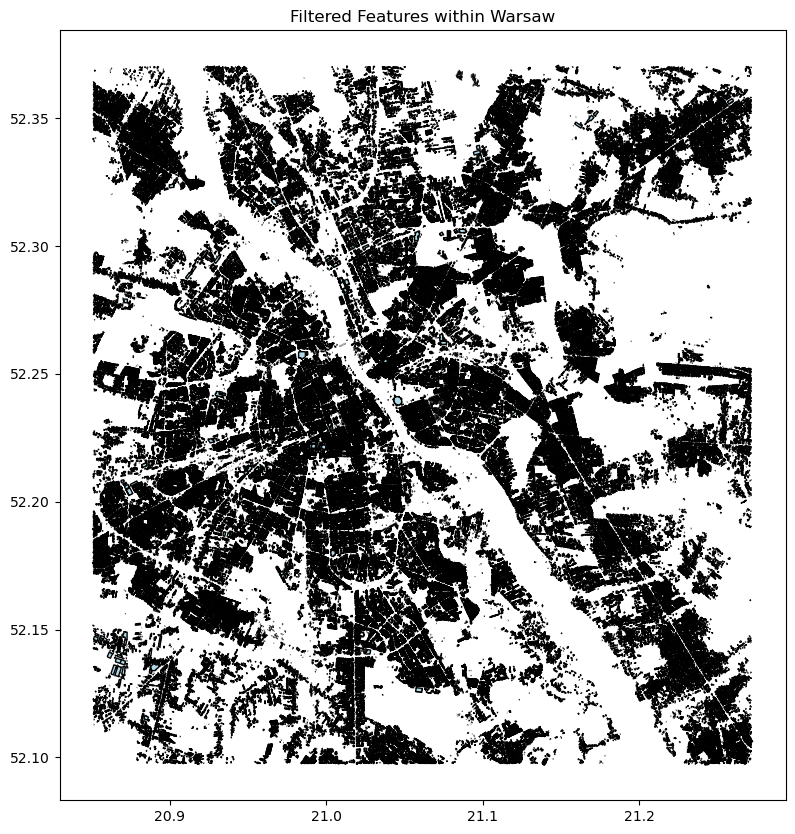

In [19]:
import matplotlib.pyplot as plt

# Plot filtered features
gdf_warsaw.plot(figsize=(10, 10), color='lightblue', edgecolor='black')
plt.title("Filtered Features within Warsaw")
plt.show()

In [ ]:
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
import fiona

# 1. Load POIs layer
shapefile_path = "path/to/mazowieckie-latest-free.shp"
layer = "gis_osm_pois_free_1"  # could also try 'gis_osm_pois_a_free_1'
gdf = gpd.read_file(shapefile_path, layer=layer)

# 2. Filter for 'parking' in fclass
gdf_parking = gdf[gdf['fclass'] == 'parking']

# 3. Define approximate bounding box for Warsaw
warsaw_bbox = box(20.8514, 52.0977, 21.2712, 52.3701)

# 4. Ensure CRS is WGS84 and filter to Warsaw
gdf_parking = gdf_parking.to_crs(epsg=4326)
gdf_parking_warsaw = gdf_parking[gdf_parking.geometry.intersects(warsaw_bbox)]

print(f"Found {len(gdf_parking_warsaw)} parking features in Warsaw")

# 5. Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf_parking_warsaw.plot(ax=ax, color='orange', markersize=5)
plt.title("Parking Locations in Warsaw (OSM POIs)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [ ]:
gdf.plot(figsize=(10, 10), edgecolor='black', color='lightblue')


In [5]:

# Check the coordinate reference system (CRS)
print(gdf.crs)

EPSG:4326


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 1️⃣ Load the shapefile
shapefile_path = "path/to/your/file.shp"
gdf = gpd.read_file(shapefile_path)

# 2️⃣ Basic info about the shapefile
print("First 5 rows of the GeoDataFrame:")
print(gdf.head())

print("\nColumns (attributes) available:")
print(gdf.columns)

print("\nCoordinate Reference System (CRS):")
print(gdf.crs)

print("\nTotal number of geometries (features):")
print(len(gdf))

# 3️⃣ Summary statistics (for numeric columns)
print("\nSummary statistics:")
print(gdf.describe())

# 4️⃣ Plot the geometries
gdf.plot(figsize=(10, 10), edgecolor='black', color='lightblue')
plt.title("Basic Map of the Shapefile")
plt.show()

# 5️⃣ Optional: explore unique values in a column (e.g., 'NAME' of regions)
if 'NAME' in gdf.columns:
    print("\nUnique region names:")
    print(gdf['NAME'].unique())